In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

matplotlib.rcParams.update({'font.size': 14})

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
outpath = ""

In [3]:
gene = "CD47"
donor_pos = [108057477,108051939,108050578,108049619]
acceptor_pos = [108047292]

In [4]:

# create a color dictionary for tissues
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

In [7]:
in_path = ""
datanames = ["TSP1_10x_with_postprocessing_newann_" + gene,"TSP2_10x_rerun_with_postprocessing_newann_" + gene,"TSP14_10x_Muscle_Lung_Blood_Bladder_newann_" + gene]
dfs = []
cell_lim = 5
read_lim = 1

rank_dict = {108057477 : 4,108051939 : 3,108050578 : 2,108049619 : 1}

for dataname in tqdm(datanames):
  
  df = pd.read_parquet("{}{}.pq".format(in_path, dataname))
  df = df[~df["compartment"].isna()]
  # subset to only junctions contributing to exon skipping event
  df = df[df["geneR1A_uniq"] == gene]
  df = df[df["juncPosR1A"].isin(donor_pos) & (df["juncPosR1B"].isin(acceptor_pos))]
  if df.shape[0] == 0:
    df = pd.read_parquet("{}{}.pq".format(in_path, dataname),columns=["cell","geneR1A_uniq","juncPosR1A","juncPosR1B","numReads", "tissue","compartment","cell_ontology_class"])
    df["temp"] = df["juncPosR1A"]
    df["juncPosR1A"] = df["juncPosR1B"]
    df["juncPosR1B"] = df["temp"]
    df = df[~df["compartment"].isna()]
    # subset to only junctions contributing to exon skipping event
    df = df[df["geneR1A_uniq"] == gene]
    df = df[df["juncPosR1A"].isin(donor_pos) & (df["juncPosR1B"].isin(acceptor_pos))]    

  df["total_numReads"] = df["cell"].map(df.groupby("cell")["numReads"].sum())

  df = df[df["total_numReads"] > read_lim]

  # rank donors
  df["rank"] = df["juncPosR1A"].map(rank_dict)
  df["read_x_rank"] = df["numReads"]*df["rank"]
  df["read_x_rank_cell"] = df.groupby("cell")["read_x_rank"].transform("sum")
  
  
  df["numReads_cell"] = df.groupby("cell")["numReads"].transform("sum")
  df["rank_mean"] = df["read_x_rank_cell"]/df["numReads_cell"]


  df["ontology"] = df["tissue"] + df["compartment"] + df["cell_ontology_class"]
  df["num_cells_ont"] = df["ontology"].map(df.groupby("ontology")["cell"].nunique())
  df = df[df["num_cells_ont"] > cell_lim]

  df = df.drop_duplicates("cell")

  dfs.append(df)


100%|██████████| 3/3 [00:00<00:00, 14.01it/s]


In [8]:
shared_onts = set(dfs[0]["ontology"].unique()).intersection(set(dfs[1]["ontology"].unique())).intersection(set(dfs[2]["ontology"].unique()))
len(shared_onts)
subdfs = []
for i in range(len(dfs)):
  dfs[i]["ont_mean"] = dfs[i].groupby("ontology")["rank_mean"].transform("mean")
  subdfs.append(dfs[i].drop_duplicates("ontology")[["ontology","ont_mean"]])
sub = subdfs[0].merge(subdfs[1],on="ontology").merge(subdfs[2],on="ontology")
sub["mean"] = sub[["ont_mean_x","ont_mean_y","ont_mean"]].mean(axis=1)
sub = sub.sort_values("mean")
order_ontologies = sub["ontology"]
order = {ont : val for ont, val in zip(order_ontologies, range(len(order_ontologies)))}
for i in range(len(dfs)):
  dfs[i] = dfs[i][dfs[i]["ontology"].isin(shared_onts)]
  dfs[i]["ontology2"] = dfs[i]["compartment"] + dfs[i]["tissue"] + dfs[i]["cell_ontology_class"]
#   dfs[i]["ontology2"] =  dfs[i]["tissue"] + dfs[i]["cell_ontology_class"]
  dfs[i]["order"] = dfs[i]["ontology"].map(order)
  dfs[i] = dfs[i].sort_values(["compartment","order"])
mapping = dfs[0].drop_duplicates("ontology")[["ontology","cell_ontology_class"]]
map_onts = dict(zip(mapping.ontology, mapping.cell_ontology_class))
yticks = list(dfs[i].drop_duplicates("ontology")["cell_ontology_class"])#order_ontologies#list(dfs[0].drop_duplicates("ontology2")[["ontology2","cell_ontology_class"]].sort_values("ontology2")["cell_ontology_class"])
y_vals = []
prev = "Endothelial"
for k, v in zip(range(1,len(shared_onts)),sorted(dfs[0]["ontology2"].unique())):
  if not v.startswith(prev):
    print(v)
    prev = v[:5]
    y_vals.append(k - 1.5)

epithelialBladderbladder urothelial cell
immuneLungmacrophage
stromalBladderfibroblast


/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


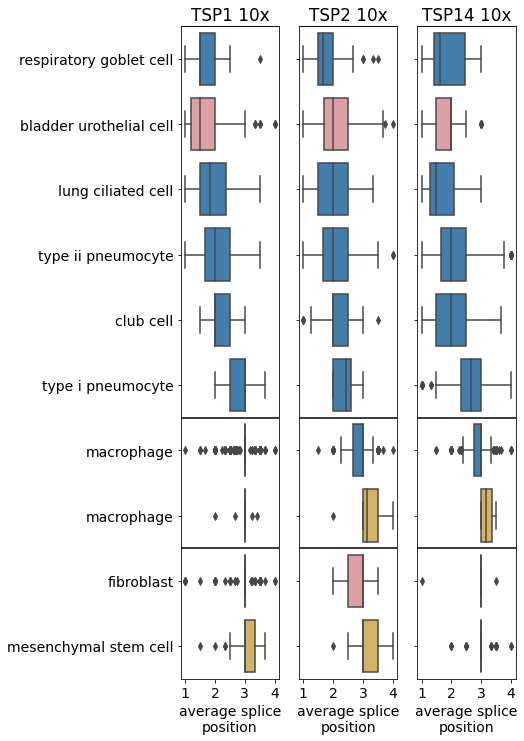

In [9]:
palette = tissue_colors()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(6,12))

g1 = sns.boxplot(x="rank_mean",y="ontology",hue="tissue",dodge=False,data=dfs[0],orient="h",palette = palette,ax=ax1)

g2 = sns.boxplot(x="rank_mean",y="ontology",hue="tissue",dodge=False,data=dfs[1],orient="h",palette = palette,ax=ax2)
g3 = sns.boxplot(x="rank_mean",y="ontology",hue="tissue",dodge=False,data=dfs[2],orient="h",palette = palette,ax=ax3)

g1.legend_.remove()
g2.legend_.remove()
g3.legend_.remove()
g1.set_title("TSP1 10x")
g2.set_title("TSP2 10x")
g3.set_title("TSP14 10x")
g1.axes.set_ylabel("")
g2.axes.set_ylabel("")
g3.axes.set_ylabel("")


g1.axes.set_xlabel("average splice\nposition")
g2.axes.set_xlabel("average splice\nposition")
g3.axes.set_xlabel("average splice\nposition")
g2.set(yticklabels=[])
g3.set(yticklabels=[])
g1.set(yticklabels=yticks)
ax1.set_xticks(np.arange(1,5))
ax2.set_xticks(np.arange(1,5))
ax3.set_xticks(np.arange(1,5))

for y in y_vals:
  ax1.axhline(y=y,color="black")
  ax2.axhline(y=y,color="black")
  ax3.axhline(y=y,color="black")

plt.savefig("{}{}_colored_by_tissue_box_{}_{}.png".format(outpath,gene,cell_lim,read_lim),bbox_inches="tight")
plt.savefig("{}{}_colored_by_tissue_box_{}_{}.pdf".format(outpath,gene,cell_lim,read_lim),format="pdf",bbox_inches="tight")

plt.show()